## Linear Classifiers -- understanding difference b/w generative and discriminative learning 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Logistic regression -- A Discriminative Algorithm

In [2]:
def generate_data_classification(m = 50, n=2, phi=0.5):
    """
    Inputs
        m : number of samples
        n : number of features (setting to 2 by default for visualization)
        phi: "fraction of samples that are from class 0" -- also known as class priors
        
    Outputs
        X : matrix of features (m x n)
        y : class labels (m x 1) where each entry is either 0 or 1 
    """

    #generate the mean vectors and the covariance matrix
    mu_0 = 1 * np.ones((n,1)) #lot of separation between the means, then the data will be "separable"
    mu_1 = -1 * np.ones((n,1))
    sigma = 3 * np.eye(n)
    #sigma = np.random.randn()
    #sigma = np.diag([1,2])

    #first generate class labels
    bern_idx = np.random.rand(m, 1) #samples from unifrom random distribution (it is between 0,1)
    y = 1 * (bern_idx >= phi) #this is a vector of size m, each entry is 0,1
    
    #now generate X
    X = np.zeros((m, n))
    for ii in range(m):
        if (y[ii] == 0):
            xtmp = np.sqrt(sigma) @ np.random.randn(n, 1) + mu_0
                
        else:
            xtmp = np.sqrt(sigma) @ np.random.randn(n,1) + mu_1
        
        X[ii:ii + 1, :] = xtmp.T
    return X, y

generate training data

In [3]:
m_train = 100
n = 2
phi = 0.5
X_train,  y_train = generate_data_classification(m_train, n, phi)
print(X_train.shape, y_train.shape)

(100, 2) (100, 1)


generate test data -- same "parameters", but new values! 

In [4]:
m_test = 50
n = 2
phi = 0.5 
X_test,  y_test = generate_data_classification(m_test, n, phi)
print(X_test.shape, y_test.shape)

(50, 2) (50, 1)


let us visualize the data

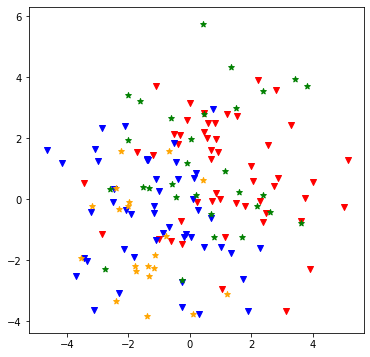

In [5]:
X_zero_train = np.array([np.array(X_train[ii,:]) for ii in range(m_train) if y_train[ii] == 0])
X_one_train = np.array([np.array(X_train[ii,:]) for ii in range(m_train) if y_train[ii] == 1])

X_zero_test = np.array([np.array(X_test[ii,:]) for ii in range(m_test) if y_test[ii] == 0])
X_one_test = np.array([np.array(X_test[ii,:]) for ii in range(m_test) if y_test[ii] == 1])


plt.figure(figsize=(6,6))
plt.scatter(X_zero_train[:,0], X_zero_train[:, 1], color='red', marker='v')
plt.scatter(X_one_train[:,0], X_one_train[:, 1], color='blue', marker='v')

plt.scatter(X_zero_test[:,0], X_zero_test[:, 1], color='green', marker='*')
plt.scatter(X_one_test[:,0], X_one_test[:, 1], color='orange', marker='*')


plt.show()

#### Training the Logistic Regression model -- same as before, use gradient descent

In [6]:
#same functions as in previous sessions
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def neg_log_cost(theta, X, y): #referred to as cross entropy loss
    """
    X is feature matrix
    y is class label
    theta is "hyperplane"
    """
    
    cost_eval = 0
    m, n = X.shape
    for ii in range(m):
        xtmp = X[ii:ii+1, :]
        #print(theta.shape)
        htheta_xtmp = sigmoid(np.squeeze(xtmp).dot(np.squeeze(theta))) #h_{theta}(x)
        #print(htheta_xtmp.shape)
        cost_eval -= y[ii] * np.log(htheta_xtmp + np.finfo(float).eps) + (1 - y[ii]) * np.log(1 - htheta_xtmp + np.finfo(float).eps)
    #print(cost_eval)
    return 1/m * cost_eval 


#log - logistic regression
def gradient_descent_log(X, y, theta_init, max_iter=1000, step_size = 1e-2):
    theta_list = [theta_init]
    m, n = X.shape
    for _ in range(max_iter):
        grad = 0
        for ii in range(m):
            xtmp = X[ii:ii+1, :]
            htheta_xtmp = sigmoid(np.squeeze(xtmp).dot(np.squeeze(theta_init)))
            grad -= (y[ii] - htheta_xtmp) * xtmp.T
            
        theta_new  = theta_init - step_size * grad / m
        theta_init = theta_new
        #theta -= step_size * grad / m
        theta_list.append(theta_new) 
        
    return np.squeeze(np.array(theta_list))

def cost_vals(X, y, theta_list):
    max_iter = theta_list.shape[0]
    err = []
    for ii in range(max_iter):
        err_tmp = neg_log_cost(theta_list[ii], X, y)
        err.append(err_tmp)
    return err

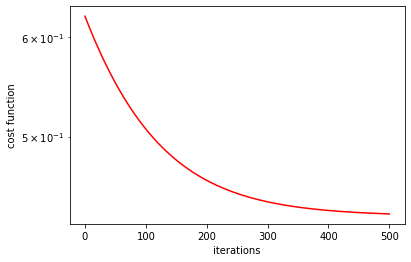

In [7]:
##initialize "hyper-parameters" and learn "theta"
max_iter = 500
step_size = 1e-2

theta_list = gradient_descent_log(X_train, y_train, np.random.randn(n,1), max_iter, step_size)

# visualize cost decay to see if everything is good
cost_decay = cost_vals(X_train, y_train, theta_list)

plt.plot(cost_decay, 'r')
plt.yscale("log")
plt.xlabel('iterations')
plt.ylabel('cost function')
plt.show()

#### Testing the Logistic Regression model

In [8]:
#first we need a function to evaluate accuracy

def acc_eval_lr(X, y, theta):
    """
    Inputs:
        X -- this is test data features
        y -- this is test data labels
        theta -- this is an estimate from learning phase
        
    Output: 
        acc: accuracy over this dataset -- between 0 and 1 
    
    """
    
    
    m_test, n_test = X.shape 
    
    #writing using for loops for clarity -- can you eliminate this loop ? 
    yhat = np.zeros_like(y)
    
    for ii in range(m_test):
        xtmp = X[ii:ii+1, :]
        htheta_xtmp = sigmoid(np.squeeze(xtmp).dot(np.squeeze(theta)))
        if(htheta_xtmp >= 1 - htheta_xtmp):
            yhat[ii] = 1
        else:
            yhat[ii] = 0
    
    correct_idx = [1 for ii in range(m_test) if yhat[ii] == y[ii]] ##list comprehension again
    num_correct = sum(correct_idx)
    
    acc = num_correct/m_test
    return acc
    
    
            
test_acc = acc_eval_lr(X_test, y_test, theta_list[-1])
train_acc = acc_eval_lr(X_train, y_train, theta_list[-1])
print("Test Accuracy for Logistic Regression = ", test_acc, '\n')
print("Train Accuracy for Logistic Regression = ", train_acc)

Test Accuracy for Logistic Regression =  0.78 

Train Accuracy for Logistic Regression =  0.82


great, our algorithm seems to work!! Let us look at GDA 

### Gaussian Discriminant Analysis -- A Generative Algorithm (learning paradigm)

generative learning requires statistical estimation methods whereas discriminative learning require optimization based methods

#### Training GDA  -- need to estimate _all_ the parameters! 

In [9]:
def train_GDA(X, y):
    """
    Inputs: 
        X -- training data features
        y - training data labels
        
    Outputs:
        phi - prior on class label distribution
        mu_0 - mean of class 0
        mu_1 - mean of class 1
        Sigma - a diagonal covariance matrix shared across the classes
    """
    m_train, n_train = X.shape #computing the number of features, and samples 
    
    #first we estimate the priors, phi
    #we assumed that y was a bernoulli r.v. with parameter (probability of "success" being phi) 
    idx_label_0 = [1 for ii in range(m_train) if y[ii] == 0]
    phi = sum(idx_label_0)/m_train #empirical average from data -- approximation to nature's phi!
    
    
    #next we estimate the means
    X_zero = np.array([np.array(X[ii,:]) for ii in range(m_train) if y[ii] == 0])
    X_one = np.array([np.array(X[ii,:]) for ii in range(m_train) if y[ii] == 1])
    
    mu_0 = np.mean(X_zero, axis=0) ##be clear about which axis you are taking mean over
    mu_1 = np.mean(X_one, axis=0) 
    
    #next we estimate the diagonal covariance
    ##covariance is diagonal!
    sigma = np.zeros((n_train, n_train))
    for ii in range(m_train):
        xtmp = np.squeeze(X[ii:ii+1, :])
        for jj in range(n_train):
            if(y[ii] == 0):
                mean_tmp = mu_0
            else:
                mean_tmp = mu_1
            sigma[jj, jj] += (xtmp[jj] - mean_tmp[jj]) ** 2
    sigma = sigma / m_train
    return phi, mu_0, mu_1, sigma
    
    

phi_hat, mu_0_hat, mu_1_hat, sigma_hat = train_GDA(X_train, y_train)

print('phi_hat =  \n', phi_hat, '\n\n\n')

print('mu_0_hat =  \n', mu_0_hat, '\n\n\n')

print('mu_1_hat =  \n', mu_1_hat, '\n\n\n')

print('sigma_hat =  \n', sigma_hat)


phi_hat =  
 0.51 



mu_0_hat =  
 [1.17130267 0.80663801] 



mu_1_hat =  
 [-1.10280601 -0.52004195] 



sigma_hat =  
 [[2.98826887 0.        ]
 [0.         2.94078476]]


Okay, we have learnt all the parameters for GDA. let us validate our model! 

In [10]:
#let us write a function to estimate the guassian pdf value ##norm pdf
def gaussian_value(x, mu, sigma):
    n,  = x.shape
    n = float(n)
    norm_factor = ((2 * np.pi) ** (n/2)) * ((np.linalg.det(sigma)) ** 0.5)
    exp_val = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x-mu)
    return (1 / norm_factor) * np.exp(exp_val)
    

def acc_eval_gda(X, y, phi, mu_0, mu_1, sigma):
    """
    Inputs:
        X -- this is test data features
        y -- this is test data labels
    parameters:
        phi - estimate of class priors
        mu_0,mu_1 - estimate of means of two classes
        sigma - estimate of shared covariance 
        
    Output: 
        acc: accuracy over this dataset
    
    """
    
    
    m_test, n_test = X.shape 
    
    #writing using for loops for clarity -- can you eliminate this loop ? 
    yhat = np.zeros_like(y)
    for ii in range(m_test):
        xtmp = np.squeeze(X[ii:ii+1, :])
        val0 = gaussian_value(xtmp, mu_0, sigma) * (1-phi)
        val1 = gaussian_value(xtmp, mu_1, sigma) * (phi)
        yhat[ii] = 0 if (val0 >= val1) else 1   #not a great or readable way to write code
    
    correct_idx = [1 for ii in range(m_test) if yhat[ii] == y[ii]]
    num_correct = sum(correct_idx)
    acc = num_correct/m_test
    return acc


test_acc = acc_eval_gda(X_test, y_test, phi_hat, mu_0_hat, mu_1_hat, sigma_hat)
print("Test Accuracy for GDA = ", test_acc)

Test Accuracy for GDA =  0.76


Why is this a linear classifier??

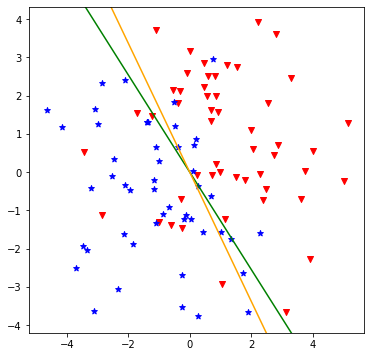

In [11]:
X_zero = np.array([np.array(X_train[ii,:]) for ii in range(m_train) if y_train[ii] == 0])
X_one = np.array([np.array(X_train[ii,:]) for ii in range(m_train) if y_train[ii] == 1])
    
final_theta = theta_list[-1]

plt.figure(figsize=(6,6))
plt.scatter(X_zero[:,0], X_zero[:, 1], color='red', marker='v')
plt.scatter(X_one[:,0], X_one[:, 1], color='blue', marker='*')
ax  = plt.gca()
ax.autoscale(False)
classifier_theta0 = np.array(ax.get_xlim())
classifier_theta1 = -(classifier_theta0 * final_theta[0])/final_theta[1]
plt.plot(classifier_theta0, classifier_theta1, '-', c="green")



w_gda = np.linalg.inv(sigma_hat) @ (mu_0_hat - mu_1_hat)

gda_theta0 = np.array(ax.get_xlim())
gda_theta1 = -(gda_theta0 * w_gda[0])/w_gda[1]
plt.plot(gda_theta0, gda_theta1, '-', c="orange")

plt.show()
